In [1]:
from autogluon.tabular import TabularDataset, TabularPredictor
import pandas as pd
import numpy as np

from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight

# Preprocessing Data

In [ ]:
data_root = "../data/"
seed = 27

df = TabularDataset(data_root + "train_dataset.csv")
df = df.reset_index(drop=True)
# psuedo = TabularDataset(data_root + 'public_dataset_without_gt_latlon.csv')
# psuedo = pd.read_csv(data_root + 'public_dataset_without_gt_latlon.csv')
# psuedo_y = TabularDataset('top1.csv')
# psuedo = pd.concat([psuedo, psuedo_y], axis = 1)
df

,ID,pms_i_ymd,Area,Province,Shop Name,gender,date_of_birth_week,date_of_birth,marital_status,number_of_children,...,Mortgage_balance,Credit Card_balance,Automobile installment purchase_balance,Other installment purchase_balance,Loan for agriculture_balance,Other Loans_balance,Bank inquiry_count,Consumer finance inquiry_count,Leasing enquiry_count,default_12month
0,202412000001,2018/4/2,Bangkok Metropolitan Region,Bangkok,Silom Complex,F2,6,1971/5/18,1,2,...,0.0,0.0,0.0,0.0,30000.0,0.0,12,6,0,0
1,202412000002,2018/4/2,Bangkok Metropolitan Region,Bangkok,Silom Complex,M,4,1983/1/5,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
2,202412000003,2018/4/3,Bangkok Metropolitan Region,Bangkok,Silom Complex,F2,5,1992/11/19,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,2,1,0,0
3,202412000004,2018/4/4,Bangkok Metropolitan Region,Bangkok,Silom Complex,M,7,1990/11/3,1,2,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
4,202412000005,2018/4/4,Bangkok Metropolitan Region,Bangkok,Silom Complex,F2,6,1994/12/16,3,1,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32519,202412049586,2018/8/31,webpak,webpak,webpak,F2,3,1995/10/24,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
32520,202412049587,2018/8/31,webpak,webpak,webpak,F2,3,1979/3/30,1,0,...,0.0,0.0,267504.0,0.0,0.0,0.0,0,0,0,0
32521,202412049588,2018/8/31,webpak,webpak,webpak,M,2,1992/5/11,1,0,...,0.0,0.0,0.0,65780.0,0.0,0.0,0,1,0,0
32522,202412049589,2018/8/31,webpak,webpak,webpak,M,2,1989/6/12,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,2,1,0


In [3]:
# print(df.iloc[:2].to_json(orient='records'))

## Train data

### Eda

In [11]:
# check data type and missing values
df.info()
# df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32524 entries, 0 to 32523
Data columns (total 61 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   ID                                       32524 non-null  int64  
 1   pms_i_ymd                                32524 non-null  object 
 2   Area                                     32524 non-null  object 
 3   Province                                 32524 non-null  object 
 4   Shop Name                                32524 non-null  object 
 5   gender                                   32524 non-null  object 
 6   date_of_birth_week                       32524 non-null  int64  
 7   date_of_birth                            32524 non-null  object 
 8   marital_status                           32524 non-null  int64  
 9   number_of_children                       32524 non-null  int64  
 10  postal_code                              32524

In [7]:
df.isna().sum()

ID                                    0
pms_i_ymd                             0
Area                                  0
Province                              0
Shop Name                             0
                                  ...  
Other Loans_balance               12945
Bank inquiry_count                    0
Consumer finance inquiry_count        0
Leasing enquiry_count                 0
default_12month                       0
Length: 61, dtype: int64

In [ ]:
def print_high_null_columns(df, threshold=0.01):
  """
  Print columns that have null values exceeding the specified threshold

  Parameters:
  df (pandas.DataFrame): Input dataframe to analyze
  threshold (float): Threshold for null percentage (default 0.3 or 30%)

  Returns:
  list: List of column names exceeding the null threshold
  """
  # Calculate percentage of null values for each column
  null_percentages = df.isnull().sum() / len(df)

  # Filter columns where null percentage exceeds threshold
  high_null_cols = null_percentages[null_percentages > threshold]

  # Print results
  print("\nColumns with more than {:.1%} null values:".format(threshold))
  print("-" * 50)
  for col, pct in high_null_cols.items():
    print(f"{col:<30} {pct:.2%} null values")

  # Return list of column names for potential dropping
  return list(high_null_cols.index)


print_high_null_columns(df)


Columns with more than 1.0% null values:
--------------------------------------------------
r_propose                      1.50% null values
r_additional_income            10.12% null values
r_spouse_income                8.51% null values
r_generalcode1                 59.33% null values
r_generalcode2                 59.73% null values
r_generalcode3                 3.21% null values
r_generalcode4                 4.37% null values
r_generalcode5                 3.47% null values
Overdraft_count                39.80% null values
Personal Loan_count            39.80% null values
Mortgage_count                 39.80% null values
Credit Card_count              39.80% null values
Automobile installment purchase_count 39.80% null values
Other installment purchase_count 39.80% null values
Loan for agriculture_count     39.80% null values
Other Loans_count              39.80% null values
Overdraft_balance              39.80% null values
Personal Loan_balance          39.80% null values
Mor

['r_propose',
 'r_additional_income',
 'r_spouse_income',
 'r_generalcode1',
 'r_generalcode2',
 'r_generalcode3',
 'r_generalcode4',
 'r_generalcode5',
 'Overdraft_count',
 'Personal Loan_count',
 'Mortgage_count',
 'Credit Card_count',
 'Automobile installment purchase_count',
 'Other installment purchase_count',
 'Loan for agriculture_count',
 'Other Loans_count',
 'Overdraft_balance',
 'Personal Loan_balance',
 'Mortgage_balance',
 'Credit Card_balance',
 'Automobile installment purchase_balance',
 'Other installment purchase_balance',
 'Loan for agriculture_balance',
 'Other Loans_balance']

### Process

In [ ]:
def safe_division(numerator, denominator, default=0):
  """Safe division handling division by zero"""
  return np.where(denominator != 0, numerator / denominator, default)


def drop_columns(df):
  """Drop unnecessary columns"""
  drop_columns = [
    "ID",
    "r_generalcode1",
    "r_generalcode2",
    "r_generalcode4",
    "r_generalcode5",
  ]

  return df.drop(columns=drop_columns)


def handle_missing_values(df):
  """Handle missing values with appropriate strategies"""
  df = df.copy()

  # Simple zero imputation for income
  df["r_additional_income"] = df["r_additional_income"].fillna(0)
  df["r_spouse_income"] = df["r_spouse_income"].fillna(0)

  # Business type specific imputation for credit limit
  df["r_expected_credit_limit"] = df.groupby("c_business_type")["r_expected_credit_limit"].transform(
    lambda x: x.fillna(x.median())
  )

  # Mode imputation for categorical
  df["r_generalcode3"] = df["r_generalcode3"].fillna(4)
  df["r_propose"] = df["r_propose"].fillna(6)  # less than 1.5% missing fill other category
  df["c_date_of_salary_payment"] = df["c_date_of_salary_payment"].fillna(1)  # less than 1% missing

  return df


def calculate_age(df):
  """Calculate age from date of birth"""
  df = df.copy()
  df["date_of_birth"] = pd.to_datetime(df["date_of_birth"])
  reference_date = pd.to_datetime("2024-01-01")
  df["age"] = (reference_date - df["date_of_birth"]).dt.days // 365

  df["pms_i_ymd"] = pd.to_datetime(df["pms_i_ymd"])
  # Create age at application
  df["age_application"] = (df["pms_i_ymd"] - df["date_of_birth"]).dt.days // 365

  return df.drop(["date_of_birth", "pms_i_ymd"], axis=1)


def calculate_income_features(df):
  """Calculate income-related features"""
  df = df.copy()

  # Basic income calculations
  df["total_income"] = df["c_monthly_salary"] + df["r_additional_income"]

  # Income ratios
  df["income_per_dependent"] = safe_division(df["total_income"], (df["number_of_children"] + 1))
  df["income_per_resident"] = safe_division(df["total_income"], df["number_of_resident"])

  # Drop original columns
  df = df.drop(columns=["c_monthly_salary", "r_additional_income"])

  return df


def calculate_stability_features(df):
  """Calculate stability-related features"""
  df = df.copy()

  # Employment stability
  df["employment_months"] = df["c_number_of_working_year"] * 12 + df["c_number_of_working_month"]
  df["job_stability_score"] = safe_division(df["employment_months"], df["age"], default=0).clip(max=1, min=0)

  # Living stability with minimum thresholds
  df["living_months"] = df["living_period_year"] * 12 + df["living_period_month"]
  df["residence_stability_score"] = safe_division(df["living_months"], df["age"], default=0).clip(max=1, min=0)

  # Drop original columns
  df = df.drop(
    columns=[
      "c_number_of_working_year",
      "c_number_of_working_month",
      "living_period_year",
      "living_period_month",
    ]
  )

  return df


def calculate_risk_features(df):
  """Calculate risk-related features"""
  df = df.copy()

  # Credit inquiries
  df["total_inquiries"] = df["Bank inquiry_count"] + df["Consumer finance inquiry_count"]
  df["high_inquiry_flag"] = (df["total_inquiries"] > 3).astype(int)

  # Debt metrics
  df["debt_burden"] = safe_division(df["r_allloan_amount"], (df["total_income"] * 12)).clip(min=0, max=10)
  df["credit_limit_ratio"] = safe_division(df["r_expected_credit_limit"], df["total_income"]).clip(min=0, max=10)

  # Business risk
  business_risk_map = {
    16: 1,
    14: 1,  # Low risk (government, education)
    15: 2,
    11: 2,
    12: 2,  # Medium-low risk (hospital, finance, insurance)
    4: 3,
    7: 3,  # Medium risk (manufacturing, business service)
    8: 4,
    5: 4,  # High risk (individual service, merchant)
  }
  df["business_risk_level"] = df["c_business_type"].map(business_risk_map).fillna(3)

  # Composite risk score
  df["high_risk_flags"] = (
    (df["living_months"] < 12).astype(int)
    + (df["employment_months"] < 12).astype(int)
    + (df["debt_burden"] > 0.5).astype(int)
    + (df["high_inquiry_flag"])
  )

  return df


def calculate_debt_profile(df):
  """Calculate comprehensive debt profile features"""
  df = df.copy()

  # Total debt exposure
  df["total_debt"] = (
    df["Overdraft_balance"]
    + df["Personal Loan_balance"]
    + df["Mortgage_balance"]
    + df["Credit Card_balance"]
    + df["Automobile installment purchase_balance"]
    + df["Other installment purchase_balance"]
    + df["Loan for agriculture_balance"]
    + df["Other Loans_balance"]
  )

  # Debt diversity score
  df["debt_products_count"] = (
    (df["Overdraft_count"] > 0).astype(int)
    + (df["Personal Loan_count"] > 0).astype(int)
    + (df["Mortgage_count"] > 0).astype(int)
    + (df["Credit Card_count"] > 0).astype(int)
    + (df["Automobile installment purchase_count"] > 0).astype(int)
  )

  # Average debt per product
  df["avg_debt_per_product"] = safe_division(df["total_debt"], df["debt_products_count"])

  return df


def calculate_purpose_features(df):
  """Calculate features related to loan purpose and intent"""
  df = df.copy()

  # Combine expected credit limit with purpose
  df["credit_purpose_ratio"] = safe_division(
    df["r_expected_credit_limit"], df["r_propose"].map(df.groupby("r_propose")["r_expected_credit_limit"].median())
  )

  return df


def define_data_type(df):
  """Define data types for each column"""
  df = df.copy()

  category_cols = [
    "Area",
    "Province",
    "Shop Name",
    "apply",
    "c_business_type",
    "c_employment_status",
    "c_occupation",
    "c_position",
    "c_salary_payment_methods",
    "date_of_birth_week",
    "gender",
    "marital_status",
    "media",
    "r_generalcode1",
    "r_generalcode2",
    "r_generalcode3",
    "r_generalcode4",
    "r_generalcode5",
    "tel_category",
    "type_of_residence",
  ]
  for col in category_cols:
    if col in df.columns:
      df[col] = df[col].astype("category")

  return df


def preprocess(df):
  """Main preprocessing pipeline"""
  df = df.copy()

  # Basic preprocessing
  df = drop_columns(df)
  df = handle_missing_values(df)
  df = df.fillna(0)

  # Feature engineering
  df = calculate_age(df)
  df = calculate_income_features(df)
  df = calculate_stability_features(df)
  df = calculate_risk_features(df)
  df = calculate_debt_profile(df)
  df = calculate_purpose_features(df)

  df = define_data_type(df)
  # Encoding and scaling
  # df = encode_categorical_features(df)

  # df = df.replace([np.inf, -np.inf], np.nan)
  return df

In [ ]:
df["r_allloan_case"].value_counts()

r_allloan_case
0.0          18415
1.0           9598
2.0           3543
3.0            795
4.0             94
5.0             25
6.0              9
10000.0          5
7.0              4
10.0             3
15000.0          3
30000.0          3
100000.0         2
2110000.0        2
8.0              2
19000.0          2
18000.0          1
16700.0          1
25600.0          1
12000.0          1
17500.0          1
11700.0          1
14100.0          1
15400.0          1
40000.0          1
11000.0          1
75000.0          1
150000.0         1
11.0             1
22000.0          1
16000.0          1
20000.0          1
33000.0          1
53000.0          1
8200.0           1
Name: count, dtype: int64

In [25]:
data = preprocess(df)

# data = data.dropna()
data["y"] = data["default_12month"].astype("int")

data = data.drop(columns=["default_12month"])
data = data.reset_index(drop=True)

# pd.set_option('display.max_columns', None)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32524 entries, 0 to 32523
Data columns (total 67 columns):
 #   Column                                   Non-Null Count  Dtype   
---  ------                                   --------------  -----   
 0   Area                                     32524 non-null  category
 1   Province                                 32524 non-null  category
 2   Shop Name                                32524 non-null  category
 3   gender                                   32524 non-null  category
 4   date_of_birth_week                       32524 non-null  category
 5   marital_status                           32524 non-null  category
 6   number_of_children                       32524 non-null  int64   
 7   postal_code                              32524 non-null  int64   
 8   tel_category                             32524 non-null  category
 9   number_of_resident                       32524 non-null  int64   
 10  type_of_residence                 

In [26]:
test_size = int(0.2 * len(data))

test_data = data.sample(test_size, random_state=seed)
train_data = data.drop(test_data.index)
train_data = train_data.reset_index(drop=True)
train_data

,Area,Province,Shop Name,gender,date_of_birth_week,marital_status,number_of_children,postal_code,tel_category,number_of_resident,...,high_inquiry_flag,debt_burden,credit_limit_ratio,business_risk_level,high_risk_flags,total_debt,debt_products_count,avg_debt_per_product,credit_purpose_ratio,y
0,Bangkok Metropolitan Region,Bangkok,Silom Complex,F2,6,1,2,10400,3,2,...,1,0.000000,4.410143,3.0,1,104484.0,1,104484.0,2.00,0
1,Bangkok Metropolitan Region,Bangkok,Silom Complex,F2,5,1,0,10170,3,6,...,0,0.079974,1.919386,3.0,1,0.0,0,0.0,1.00,0
2,Bangkok Metropolitan Region,Bangkok,Silom Complex,M,7,1,2,10500,3,2,...,0,0.000000,1.098177,3.0,0,0.0,0,0.0,0.75,0
3,Bangkok Metropolitan Region,Bangkok,Silom Complex,F2,6,3,1,10120,3,2,...,0,0.000000,1.344086,3.0,2,0.0,0,0.0,0.50,1
4,Bangkok Metropolitan Region,Bangkok,Silom Complex,F2,3,1,0,10400,3,2,...,0,0.000000,0.534188,4.0,0,0.0,0,0.0,0.25,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26015,webpak,webpak,webpak,F2,3,1,0,12120,3,3,...,0,0.000000,4.981685,3.0,1,0.0,0,0.0,1.70,0
26016,webpak,webpak,webpak,F2,3,1,0,25140,3,2,...,0,0.000000,4.882115,3.0,0,267504.0,1,267504.0,2.05,0
26017,webpak,webpak,webpak,M,2,1,0,20230,3,2,...,0,0.000000,2.192982,3.0,1,65780.0,0,0.0,1.00,0
26018,webpak,webpak,webpak,M,2,1,0,20150,3,2,...,0,0.000000,4.943733,3.0,1,56224.0,1,56224.0,3.80,0


In [ ]:
data["y"].value_counts(normalize=True)

y
0    0.870496
1    0.129504
Name: proportion, dtype: float64

In [28]:
test = TabularDataset(data_root + "public_dataset_without_gt.csv")
test = preprocess(test)
# fill with mean if number else mode
# for column in test.columns:
#     if test[column].dtype in [np.float64, np.int64]:
#         test[column].fillna(test[column].mean(), inplace=True)
#     else:
#         test[column].fillna(test[column].mode()[0], inplace=True)
test

,Area,Province,Shop Name,gender,date_of_birth_week,marital_status,number_of_children,postal_code,tel_category,number_of_resident,...,total_inquiries,high_inquiry_flag,debt_burden,credit_limit_ratio,business_risk_level,high_risk_flags,total_debt,debt_products_count,avg_debt_per_product,credit_purpose_ratio
0,Bangkok Metropolitan Region,Bangkok,Silom Complex,F2,2,2,2,10120,3,4,...,4,1,0.000000,0.699301,3.0,2,0.0,0,0.0,0.25
1,Bangkok Metropolitan Region,Bangkok,Silom Complex,F2,2,2,0,10120,3,5,...,12,1,0.138889,0.833333,3.0,1,50671.0,2,25335.5,0.50
2,Bangkok Metropolitan Region,Bangkok,Silom Complex,F2,4,1,0,10120,3,1,...,5,1,0.160985,2.272727,3.0,2,12653.0,1,12653.0,1.00
3,Bangkok Metropolitan Region,Bangkok,Silom Complex,F1,5,3,3,10530,3,6,...,14,1,0.165246,1.982947,4.0,1,51734.0,1,51734.0,2.50
4,Bangkok Metropolitan Region,Bangkok,Silom Complex,M,2,2,2,10700,3,5,...,0,0,0.000000,0.732064,4.0,0,0.0,0,0.0,0.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6562,webpak,webpak,webpak,F2,7,2,1,20230,3,2,...,3,0,0.000000,4.954128,3.0,0,6351.0,1,6351.0,2.70
6563,webpak,webpak,webpak,F2,1,1,0,20230,3,1,...,7,1,0.000000,0.000000,3.0,1,7128.0,1,7128.0,0.00
6564,webpak,webpak,webpak,M,5,2,0,21140,3,4,...,0,0,0.000000,4.906205,3.0,0,158000.0,0,0.0,1.70
6565,webpak,webpak,webpak,F2,3,1,0,20000,3,1,...,5,1,0.000000,0.983975,3.0,1,695451.0,2,347725.5,0.70


In [29]:
test.isna().sum()

Area                    0
Province                0
Shop Name               0
gender                  0
date_of_birth_week      0
                       ..
high_risk_flags         0
total_debt              0
debt_products_count     0
avg_debt_per_product    0
credit_purpose_ratio    0
Length: 66, dtype: int64

# Train

In [30]:
preset = [
  "best_quality",
  "high_quality",
  "good_quality",
  "medium_quality",
  "optimize_for_deployment",
][3]

# included = ["XGB", "GMB", "RF", "XT", "catboost"]
# excluded_model_types = ["KNN", "NN_TORCH", "catboost"]
# problem_type = "regression"
problem_type = "binary"


eval_metric = ["roc_auc", "f1", "average_precision"]

time_limit = 5 * 60
predictor = TabularPredictor(
  label="y",
  verbosity=2,
  problem_type=problem_type,
  eval_metric=eval_metric[0],
  # sample_weight="balance_weight",  # "auto_weight"
).fit(
  train_data=train_data,
  test_data=test_data,
  presets=preset,
  time_limit=time_limit,
  # included_model_types=included,
  #  excluded_model_types = excluded_model_types,
  num_bag_folds=8,  # Use 5-fold cross-validation
  refit_full=True,
  use_bag_holdout=False,
)

No path specified. Models will be saved in: "AutogluonModels/ag-20241207_183819"
Verbosity: 2 (Standard Logging)


=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.10
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 24.1.0: Thu Oct 10 21:02:45 PDT 2024; root:xnu-11215.41.3~2/RELEASE_ARM64_T8112
CPU Count:          8
Memory Avail:       2.55 GB / 16.00 GB (16.0%)
Disk Space Avail:   13.98 GB / 228.27 GB (6.1%)
Presets specified: ['medium_quality']
Beginning AutoGluon training ... Time limit = 300s
AutoGluon will save models to "/Users/tae/hackathon/24/aihack/code/AutogluonModels/ag-20241207_183819"
Train Data Rows:    26020
Train Data Columns: 66
Label Column:       y
Problem Type:       binary
Preprocessing data ...
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    2633.72 MB
	Train Data (Original)  Memory Usage: 11.58 MB (0.4% of available memory)
	Inferring da

# load model

In [3]:
model_path = "./AutogluonModels/ag-20241207_105433"
predictor = TabularPredictor.load(model_path)

# Prediction and Evaluation

In [31]:
# test on train data
top = predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                           model  score_val eval_metric  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0            WeightedEnsemble_L2   0.651534     roc_auc       4.053270  170.947586                0.002964           0.969827            2       True         14
1                CatBoost_BAG_L1   0.646409     roc_auc       0.109326   99.402329                0.109326          99.402329            1       True          7
2                 XGBoost_BAG_L1   0.637246     roc_auc       0.240282    9.793761                0.240282           9.793761            1       True         11
3              LightGBMXT_BAG_L1   0.636797     roc_auc       0.357381    1.816865                0.357381           1.816865            1       True          3
4          NeuralNetTorch_BAG_L1   0.628394     roc_auc       0.642374   23.928479                0.642374          23.928479        

/Users/tae/mambaforge/envs/gluon/lib/python3.11/site-packages/autogluon/core/utils/plots.py:169: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


In [38]:
# test on eval
predictor.leaderboard(test_data, silent=True, extra_info=True, extra_metrics=eval_metric).head(6)
# predictor.model_names()

,model,score_test,roc_auc,f1,average_precision,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,...,hyperparameters,hyperparameters_fit,ag_args_fit,features,compile_time,child_hyperparameters,child_hyperparameters_fit,child_ag_args_fit,ancestors,descendants
0,WeightedEnsemble_L2_FULL,0.633052,0.633052,0.000,0.239394,NaN,roc_auc,0.308311,NaN,10.372515,...,"{'use_orig_features': False, 'valid_stacker': True, 'max_base_models': 0, 'max_base_models_per_type': 'auto', 'save_bag_folds': True}",{},"{'max_memory_usage_ratio': 1.0, 'max_time_limit_ratio': 1.0, 'max_time_limit': None, 'min_time_limit': 0, 'valid_raw_types': None, 'valid_special_types': None, 'ignored_type_group_special': None, 'ignored_type_group_raw': None, 'get_features_kwargs': None, 'get_features_kwargs_extra': None, 'predict_1_batch_size': None, 'temperature_scalar': None, 'drop_unique': False}","[NeuralNetTorch_BAG_L1, ExtraTreesEntr_BAG_L1, RandomForestGini_BAG_L1, ExtraTreesGini_BAG_L1, XGBoost_BAG_L1, LightGBMLarge_BAG_L1, NeuralNetFastAI_BAG_L1, CatBoost_BAG_L1]",None,"{'ensemble_size': 25, 'subsample_size': 1000000}",{'ensemble_size': 25},"{'max_memory_usage_ratio': 1.0, 'max_time_limit_ratio': 1.0, 'max_time_limit': None, 'min_time_limit': 0, 'valid_raw_types': None, 'valid_special_types': None, 'ignored_type_group_special': None, 'ignored_type_group_raw': None, 'get_features_kwargs': None, 'get_features_kwargs_extra': None, 'predict_1_batch_size': None, 'temperature_scalar': None, 'drop_unique': False}","[ExtraTreesEntr_BAG_L1_FULL, XGBoost_BAG_L1_FULL, NeuralNetFastAI_BAG_L1_FULL, LightGBMLarge_BAG_L1_FULL, NeuralNetTorch_BAG_L1_FULL, RandomForestGini_BAG_L1_FULL, CatBoost_BAG_L1_FULL, ExtraTreesGini_BAG_L1_FULL]",[]
1,CatBoost_BAG_L1_FULL,0.627334,0.627334,0.005,0.236827,NaN,roc_auc,0.024749,NaN,2.903273,...,"{'use_orig_features': True, 'valid_stacker': True, 'max_base_models': 0, 'max_base_models_per_type': 'auto', 'save_bag_folds': True}",{},"{'max_memory_usage_ratio': 1.15, 'max_time_limit_ratio': 1.0, 'max_time_limit': None, 'min_time_limit': 0, 'valid_raw_types': None, 'valid_special_types': None, 'ignored_type_group_special': None, 'ignored_type_group_raw': None, 'get_features_kwargs': None, 'get_features_kwargs_extra': None, 'predict_1_batch_size': None, 'temperature_scalar': None, 'drop_unique': False}","[r_generalcode3, type_of_residence, Area, place_for_sending_information, apply, total_income, tel_category, credit_purpose_ratio, Province, c_postal_code, residence_stability_score, employment_months, marital_status, Shop Name, r_allloan_case, living_months, c_business_type, credit_limit_ratio, total_inquiries, income_per_dependent, high_risk_flags, c_employment_status, postal_code, high_inquiry_flag, date_of_birth_week, r_expected_credit_limit, c_salary_payment_methods, age, c_number_of_employee, gender, job_stability_score, c_occupation, number_of_resident, r_allloan_amount, age_applicat...",None,"{'iterations': 225, 'learning_rate': 0.05, 'random_seed': 0, 'allow_writing_files': False, 'eval_metric': 'Logloss'}",{'iterations': 225},"{'max_memory_usage_ratio': 1.0, 'max_time_limit_ratio': 1.0, 'max_time_limit': None, 'min_time_limit': 0, 'valid_raw_types': ['bool', 'int', 'float', 'category'], 'valid_special_types': None, 'ignored_type_group_special': None, 'ignored_type_group_raw': None, 'get_features_kwargs': None, 'get_features_kwargs_extra': None, 'predict_1_batch_size': None, 'temperature_scalar': None}",[],[WeightedEnsemble_L2_FULL]
2,ExtraTreesEntr_BAG_L1_FULL,0.625808,0.625808,0.000,0.229741,NaN,roc_auc,0.056543,0.282129,0.537594,...,"{'use_orig_features': True, 'valid_stacker': True, 'max_base_models': 0, 'max_base_models_per_type': 'auto', 'save_bag_folds': True, 'use_child_oof': True}",{},"{'max_memory_usage_ratio': 1.0, 'max_time_limit_ratio': 1.0, 'max_time_limit': None, 'min_time_limit': 0, 'valid_raw_types': None, 'valid_special_types': None, 'ignored_type_group_special': None, 'ignored_type_group_raw': None, 'get_featu

In [34]:
model_name = "WeightedEnsemble_L2"  # predictor.model_names()[0]
# model_name = "RandomForestGini_BAG_L1_FULL"
# model_name = "CatBoost_BAG_L2_FULL"
# model_name = "RandomForestEntr_BAG_L2_FULL"
# model_name = "CatBoost_r13_BAG_L1_FULL"

## For regression

In [ ]:
y_test = predictor.predict(test_data, model=model_name)
perf = predictor.evaluate_predictions(y_true=test_data["y"], y_pred=y_test, auxiliary_metrics=True)
perf, y_test.hist()

NameError: name 'predictor' is not defined

In [ ]:
auc_score = roc_auc_score(test_data["y"], y_test)
print(f"AUC Score: {auc_score}")

fpr, tpr, thresholds = roc_curve(test_data["y"], y_test)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.show()

NameError: name 'y_test' is not defined

In [ ]:
def eval_auc(test_data):
  global predictor
  model_names = predictor.model_names()

  y_test = test_data["y"]
  test_data_nolab = test_data.drop(columns=["y"])
  auc_roc_scores = {}
  for model_name in model_names:
    try:
      y_pred = predictor.predict(test_data_nolab, model=model_name)
    except Exception as e:
      print(f"Model {model_name} does not support predict method : {e}")
      continue
    auc_roc = roc_auc_score(y_test, y_pred)
    auc_roc_scores[model_name] = auc_roc

  top = pd.DataFrame.from_dict(auc_roc_scores, orient="index", columns=["AUC-ROC"])
  top = top.sort_values(by=["AUC-ROC"], ascending=False)
  return top

In [30]:
eval_auc(test_data)

Model LightGBMXT_BAG_L1 does not support predict method : 'NoneType' object has no attribute 'predict'
Model LightGBM_BAG_L1 does not support predict method : 'NoneType' object has no attribute 'predict'
Model CatBoost_BAG_L1 does not support predict method : 'NoneType' object has no attribute 'predict'
Model NeuralNetFastAI_BAG_L1 does not support predict method : 'NoneType' object has no attribute 'dls'
Model XGBoost_BAG_L1 does not support predict method : 'NoneType' object has no attribute 'set_params'
Model NeuralNetTorch_BAG_L1 does not support predict method : 'NoneType' object has no attribute 'predict'
Model LightGBMLarge_BAG_L1 does not support predict method : 'NoneType' object has no attribute 'predict'
Model CatBoost_r177_BAG_L1 does not support predict method : 'NoneType' object has no attribute 'predict'
Model NeuralNetTorch_r79_BAG_L1 does not support predict method : 'NoneType' object has no attribute 'predict'
Model LightGBM_r131_BAG_L1 does not support predict method

,AUC-ROC
CatBoost_BAG_L1_FULL,0.672644
CatBoost_r137_BAG_L1_FULL,0.669088
WeightedEnsemble_L2_FULL,0.668789
WeightedEnsemble_L3_FULL,0.668568
CatBoost_r9_BAG_L2_FULL,0.667053
CatBoost_BAG_L2_FULL,0.666182
CatBoost_r177_BAG_L1_FULL,0.666125
CatBoost_r177_BAG_L2_FULL,0.665734
CatBoost_r13_BAG_L1_FULL,0.663764
CatBoost_r9_BAG_L1_FULL,0.662387


In [21]:
pred = predictor.predict(test, model=model_name)
pred

NameError: name 'predictor' is not defined

## For Binary

/Users/tae/mambaforge/envs/gluon/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>]],
       dtype=object),
 {'roc_auc': 0.6698714425916246,
  'accuracy': 0.8751537515375154,
  'balanced_accuracy': 0.5,
  'mcc': 0.0,
  'f1': 0.0,
  'precision': 0.0,
  'recall': 0.0})

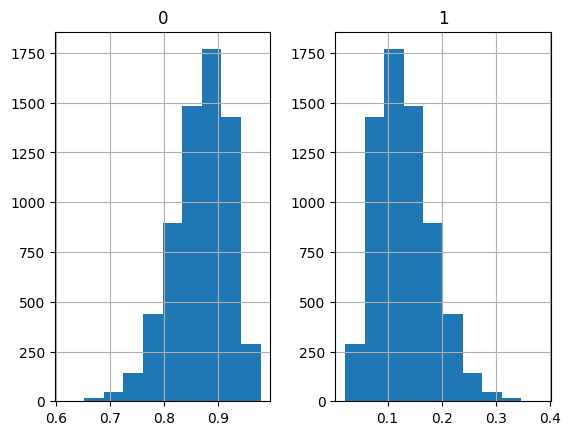

In [ ]:
y_test = predictor.predict_proba(test_data, model=model_name)
perf = predictor.evaluate_predictions(y_true=test_data["y"], y_pred=y_test, auxiliary_metrics=True)
y_test.hist(), perf

AUC Score: 0.6698714425916246


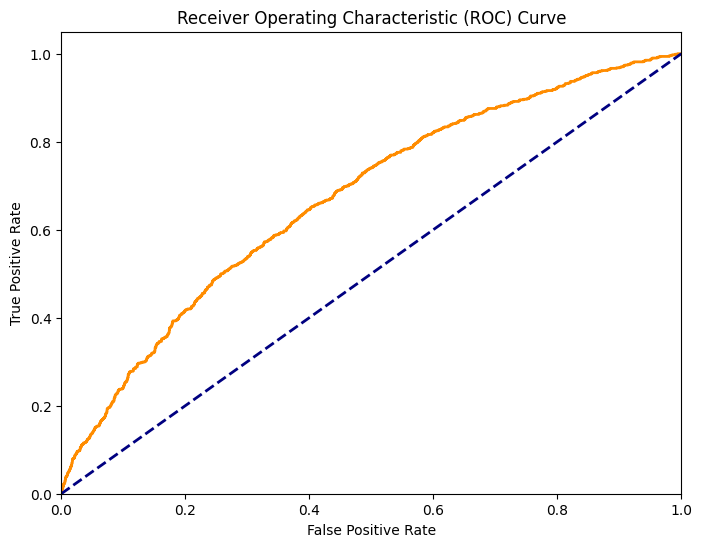

In [ ]:
auc_score = roc_auc_score(test_data["y"], y_test[1])
print(f"AUC Score: {auc_score}")

fpr, tpr, thresholds = roc_curve(test_data["y"], y_test[1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.show()

In [37]:
pred = predictor.predict_proba(test, model=model_name)[1]
pred

0       0.218680
1       0.086027
2       0.129990
3       0.081936
4       0.144191
          ...   
6562    0.130686
6563    0.176521
6564    0.082784
6565    0.119497
6566    0.169925
Name: 1, Length: 6567, dtype: float64

##### Merge 2 models with different index

In [ ]:
old_pred = pd.read_csv("not_zero.csv", index_col=0)
old_pred

pred = pd.read_csv("zero.csv", index_col=0)
pred

# Create a new series with all unique indices
all_indices = sorted(set(old_pred.index) | set(pred.index))
new_pred = pd.Series(index=all_indices, dtype=float)

# Fill in values from old predictions
for index, row in old_pred.iterrows():
  new_pred[index] = row["1"]

for index, row in pred.iterrows():
  new_pred[index] = row["1"]
new_pred
pred = new_pred

## Feature

In [46]:
predictor.feature_importance(test_data, subsample_size=1000)

Computing feature importance via permutation shuffling for 66 features using 1000 rows with 5 shuffle sets...


	334.02s	= Expected runtime (66.8s per shuffle set)
	76.95s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
Leasing enquiry_count,0.011697,0.003955,0.001355,5,0.019841,0.003554
Overdraft_balance,0.009627,0.010077,0.049749,5,0.030376,-0.011121
income_per_dependent,0.007857,0.006765,0.030121,5,0.021786,-0.006073
job_stability_score,0.005591,0.009087,0.120442,5,0.024302,-0.013119
number_of_children,0.005505,0.006544,0.066557,5,0.018979,-0.007969
...,...,...,...,...,...,...
Overdraft_count,-0.000629,0.001683,0.774716,5,0.002836,-0.004093
number_of_resident,-0.000640,0.001365,0.823020,5,0.002172,-0.003451
gender,-0.001443,0.005992,0.690649,5,0.010894,-0.013781
r_generalcode3,-0.001730,0.006178,0.717413,5,0.010991,-0.014451


# Submit

(<Axes: >, <Axes: >)

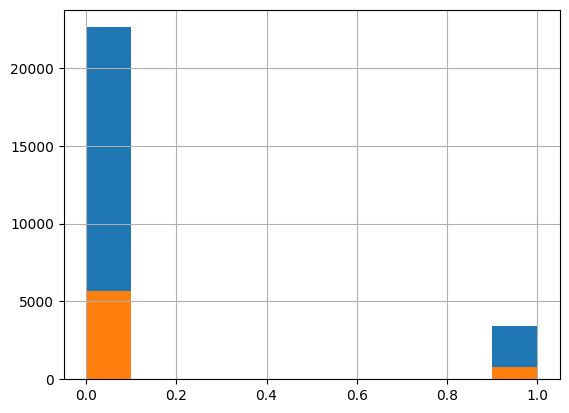

In [ ]:
train_data["y"].hist(), test_data["y"].hist()

<Axes: >

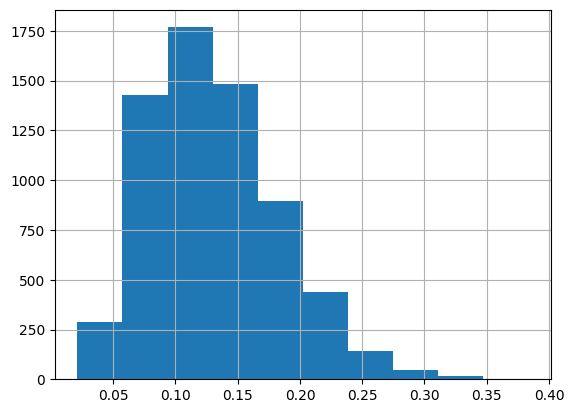

In [40]:
y_test[1].hist()

<Axes: >

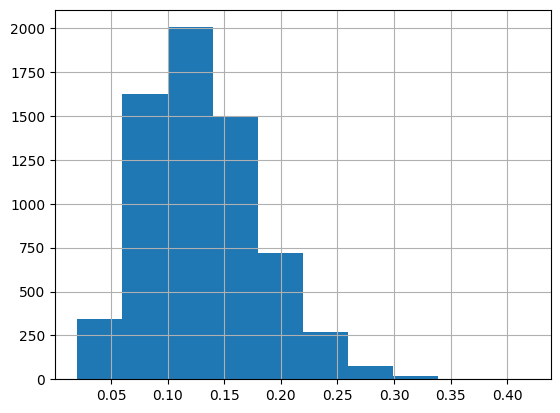

In [41]:
pred.hist()

In [ ]:
sub = pd.read_csv(data_root + "submission_template_for_public.csv")
# sub = sub[['no']]
sub

,ID,default_12month
0,2.024120e+11,0
1,2.024120e+11,0
2,2.024120e+11,0
3,2.024120e+11,0
4,2.024120e+11,0
...,...,...
6562,2.024120e+11,0
6563,2.024120e+11,0
6564,2.024120e+11,0
6565,2.024120e+11,0


In [ ]:
sub["default_12month"] = pred
sub

,ID,default_12month
0,2.024120e+11,0.218680
1,2.024120e+11,0.086027
2,2.024120e+11,0.129990
3,2.024120e+11,0.081936
4,2.024120e+11,0.144191
...,...,...
6562,2.024120e+11,0.130686
6563,2.024120e+11,0.176521
6564,2.024120e+11,0.082784
6565,2.024120e+11,0.119497


In [ ]:
sub.to_csv(f"99_day1_2_{model_name}.csv", index=False)
# sub.to_csv(".csv", index=False)

In [42]:
eval_auc(train_data)

NameError: name 'eval_auc' is not defined

In [ ]:
import os

In [ ]:
model_names = predictor.model_names()

save_path = "submission/"
os.makedirs(save_path, exist_ok=True)

for model_name in model_names:
  try:
    pred = predictor.predict(test, model=model_name)
  except:
    print(f"Model {model_name} does not support predict method")
    continue
  # Compute AUC-ROC

  sub["default_12month"] = pred
  sub.to_csv(f"{save_path}99_{model_name}.csv", index=False)